# X-Risk Exploratory Data Analysis

In this notebook we go through the existential risk database to learn about the estimates made by different people on the subject.

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style='darkgrid')
orig_size = plt.rcParams['figure.figsize']

In [102]:
# Load the data
df = pd.read_csv('./data/processed_estimates/all_estimates.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   estimator                      87 non-null     object 
 1   original_estimate              87 non-null     object 
 2   per_century_risk               87 non-null     float64
 3   estimate_confidence            87 non-null     object 
 4   conversion_confidence          87 non-null     object 
 5   reasoning                      87 non-null     object 
 6   risk_category                  87 non-null     object 
 7   estimate_confidence_numeric    87 non-null     int64  
 8   conversion_confidence_numeric  87 non-null     int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 6.2+ KB


In [103]:
# Get the unique risk categories
xrisk_categories = set(df['risk_category'])
print(f'There are {len(xrisk_categories)} unique risk categories:\n-\t{"\n-\t".join(xrisk_categories)}')

There are 10 unique risk categories:
-	dystopia
-	nuclear
-	biorisk
-	natural_risks
-	miscellaneous
-	ai
-	war
-	climate_change
-	total
-	nanotechnology


In [104]:
categories_aliases = {
    "ai": "AI",
    "natural_risks": "Natural\nRisks",
    "nanotechnology": "Nanotech",
    "climate_change": "Climate\nChange",
    "war": "War",
    "miscellaneous": "Misc",
    "biorisk": "Biorisk",
    "total": "Total\nRisk",
    "dystopia": "Dystopia",
    "nuclear": "Nuclear",
}
df['category_alias'] = df['risk_category'].map(categories_aliases)


Text(0.5, 0, 'Risk category')

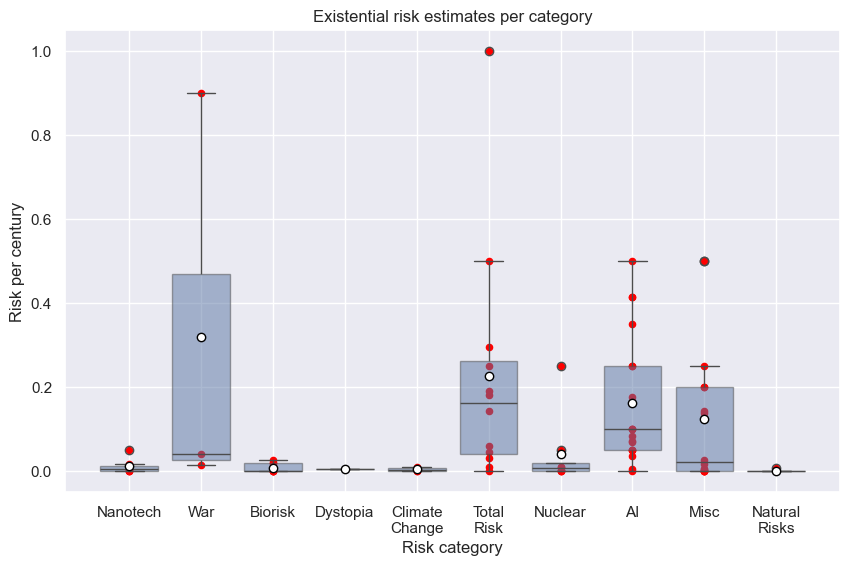

In [105]:
# Plot the risk categories as scatter plot.
ax = sns.boxplot(x='category_alias', y='per_century_risk', data=df, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"}, boxprops=dict(alpha=0.5))

df.plot(kind='scatter', x='category_alias', y='per_century_risk', color='red', figsize=(10, 6), ax=ax)

ax.set_title('Existential risk estimates per category')
ax.set_ylabel('Risk per century')
ax.set_xlabel('Risk category')


We see that the data shows a relatively wide spread for the risk categories Nanotech, War, AI, Total Risk, and Misc. Let's take a look at the outliers.


## Outliers

There are a few outliers in the data which we'll look at more in detail, to see if they were perhaps conversion errors by Claude or something else.



### Nuclear

There's a value of 25% for nuclear risk which seems suspect, given that all other values are so low.


In [106]:
# Get outlier from nanotech category and risk above 20%
nuclear_outlier = df[(df['risk_category'] == 'nuclear') & (df['per_century_risk'] > 0.2)]
nuclear_outlier

,estimator,original_estimate,per_century_risk,estimate_confidence,conversion_confidence,reasoning,risk_category,estimate_confidence_numeric,conversion_confidence_numeric,category_alias
41,Dave Denkenberger,0.29% annual,0.25,medium,medium,Annual to century using compound probability: ...,nuclear,2,2,Nuclear


In [107]:
# Print the value and reasoning
print(f'Reasoning: {nuclear_outlier["reasoning"].values[0]}')

Reasoning: Annual to century using compound probability: 1-(1-0.0029)^100. Medium confidence due to model based on expert survey.


Okay, so Claude tried to convert the value from 0.29% annual to a per century risk using compound probability, which he did correctly.

Let's confirm this:

I introduce the following variables and probabilities:

$$
\begin{align}
E&: \text{Existential catastrophe occurs} \\
P_1(E)&: \text{Existential risk per year}=0.0029 \\
P_{100}(E)&: \text{Existential risk per century}=?
\end{align}
$$

If the annual risk estimate is 0.29%, then we ask, how likely is it that this risk doesn't happen for 100 years in a row?

We can express that as: $(1-P_1(E))^{100}$, and the complement probability is that the risk will occur at least once in 100 years, so we get

$$
\begin{align}
P(R_1) &= 0.0029 \\
P(R_{100}) &= 1-P'(R_1)^{100} \\
P(R_{100}) &= 1-(1-P(R_1))^{100} \\
P(R_{100}) &= 1-(1-0.0029)^{100} \\
P(R_{100}) &\approx 0.252 \text{ or } 25\%
\end{align}
$$

To convert a period of size $a$ to another period of size $b$ we can simply replace the 100 years in the example by the number of times that period $a$ fits into $b$:

$$
P(R_{a}) = 1-(1-P(R_{b}))^{\frac{b}{a}}
$$

Claude also converted another value from 0.051% annual to 5% per century. By using the formulas above we get:

$$
\begin{align}
P(R_1) &= 0.00051 \\
P(R_{100}) &= 1-P'(R_1)^{100} \\
P(R_{100}) &= 1-(1-P(R_1))^{100} \\
P(R_{100}) &= 1-(1-0.00051)^{100} \\
P(R_{100}) &\approx 0.0497 \text{ or } 0.49\%
\end{align}
$$

So the conversion seems also correct.

### War

By looking at the data, the corresponding outlier is from an estimate by William MacAskill. The remarks were summarized as: 

> '90% conditional on x-risk occurring'.

I had to take a look at the original database to understand exactly what he meant, and it still is not very clear. In the remarks it says:

> In terms of my estimates for existential risk over the century, I would put 90% of the risk coming from wartime or something precisely because people… If you tell me someone’s done something, a country’s done something incredibly stupid and kind of against their own interest or in some sense of global interest, it’s probably happened during a war period.

Given this interpretation, we cannot validly calculate a specific war risk percentage from these statements. The 90% figure isn't a clean conditional probability that we can multiply with the 1% total risk to get his estimate for the likelihood of x-risk due to war. 

Instead, his statement describes war's role as a risk factor that interacts with and amplifies other existential risks. We'll remove the entry because it doesn't really reflect an x-risk estimate. However, we'll keep it in mind as an indication that there is at least one field expert who thinks that war is an important factor that clearly exacerbates other x-risks.


In [108]:
# Remove war outlier
df = df[df['per_century_risk'] < 0.9]


### Total Risk
There's a value of 1, or 100% existential risk per century for Total Risk. Let's investigate.

In [109]:
df[df['per_century_risk']> 0.9]

,estimator,original_estimate,per_century_risk,estimate_confidence,conversion_confidence,reasoning,risk_category,estimate_confidence_numeric,conversion_confidence_numeric,category_alias


In this case, I had to double check the original dataset, and it turns out that this estimator, Frank Tipler said, in 2019 "Personally, I now think we humans will be wiped out this century". So a 100% risk is actually accurate in this case.

First, should we remove this outlier? We might be tempted to drop such an extreme value. However, in existential risk assessment, we're dealing with expert opinions rather than natural phenomena where outliers might represent measurement errors.

Second, let's think about the nature of expert opinions. Unlike physical measurements where extreme outliers often represent errors, an extreme opinion might represent a genuinely held belief based on careful consideration. Frank Tipler is a physicist and mathematician who has published extensively on cosmology and the future of humanity. His estimate, while extreme, comes from his reasoning.

I find it notable though that his estimate was entered as "N/A" in the original database.

### Misc

There's an outlier in the misc category.

In [119]:
df[(df['risk_category'] == 'miscellaneous') & (df['per_century_risk'] > 0.3)]

,estimator,original_estimate,per_century_risk,estimate_confidence,conversion_confidence,reasoning,risk_category,estimate_confidence_numeric,conversion_confidence_numeric,category_alias,weighted_confidence_mean
65,Holden Karnofsky (human),≥50% PASTA impact this century,0.5,medium,high,Direct century estimate. Conditional on PASTA ...,miscellaneous,2,3,Misc,0.784053
67,Wei Dai,≥50% value loss from poor deliberation,0.5,medium,low,Unclear timeframe assumed to be century. Mediu...,miscellaneous,2,1,Misc,0.505239


It turns out that these estimates were directly given per century and are both at least 50%, so their values could be even higher. Claude gave them both a medium estimate confidence that might reflect the uncertainty in the estimate.

## Weighting

Now, Claude assigned confidence levels for the estimates and for the conversion themselves. We'll now explore using these data.

The goal will be to find an appropriate weighing mechanism to account for the uncertainty in the estimates and in their conversion.


Text(0.5, 0, 'Risk category')

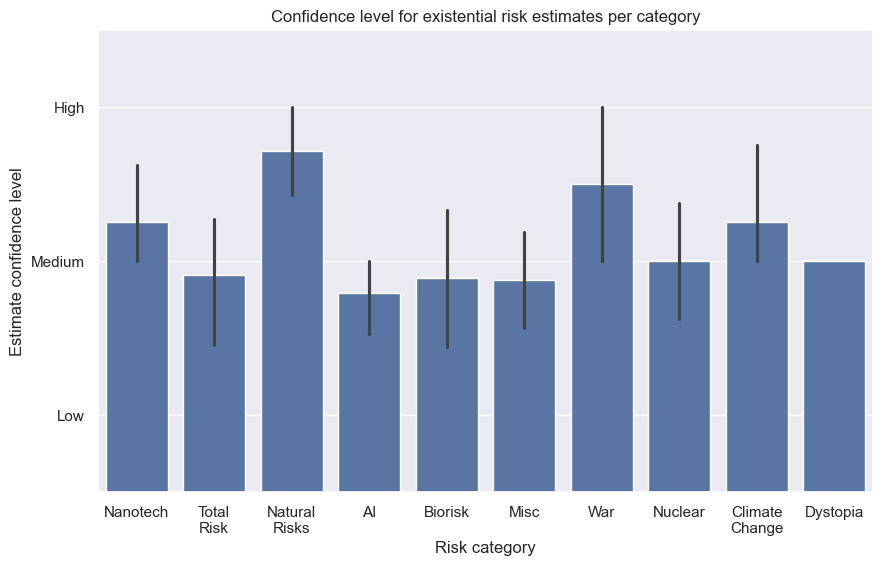

In [131]:
# Visualize the confidence level for each category in a 10 by 6 inches plot.
# Start plot from 1 since it's the lowest confidence level
df = df.sort_values('estimate_confidence_numeric', ascending=False)

# Plot the confidence level for each category sorted by confidence level
sns.set_theme(rc={'figure.figsize': (10, 6)})
ax = sns.barplot(x='category_alias', y='estimate_confidence_numeric', data=df)
ax.set_ylim(0.5, 3.5)
ax.set_yticks([1, 2, 3], ['Low', 'Medium', 'High'])
ax.set_title('Confidence level for existential risk estimates per category')
ax.set_ylabel('Estimate confidence level')
ax.set_xlabel('Risk category')

It seems that the confidence level varies from category to category. Some categories do not have variation, like Dystopia, which only has one estimate.

Let's look at the conversion confidence now.

Text(0.5, 0, 'Risk category')

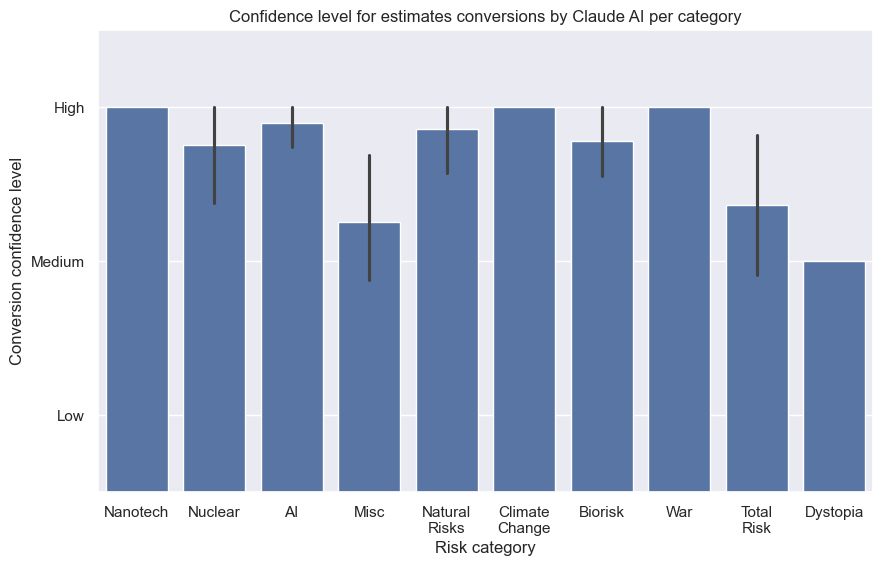

In [127]:
# Visualize the confidence level for each category.
# Start plot from 1 since it's the lowest confidence level
df = df.sort_values('conversion_confidence_numeric', ascending=False)
ax = sns.barplot(x='category_alias', y='conversion_confidence_numeric', data=df)
ax.set_ylim(0.5, 3.5)
# Set y tick labels to Low, Medium and High using the mapping above
ax.set_yticks([1, 2, 3], ['Low', 'Medium', 'High'])
ax.set_title('Confidence level for estimates conversions by Claude AI per category')
ax.set_ylabel('Conversion confidence level')
ax.set_xlabel('Risk category')

Again, it seems that the confidence in the conversion by Claude AI is good for most risk categories, except for Dystopia, which only has one estimate and the confidence in the conversion is medium.

Let's use this information to create weighted averages using both the estimate confidence and the conversion confidence.

I'll use a weighted geometric mean model, that is based on a weight $\alpha$ that describes the "relevance" of one particular weight. Since we have two weight sources (estimate confidence and conversion confidence), we can create an aggregated weight based on the weighted geometric mean that we can use compute weighted averages.

The weighted geometric mean can be computed with:

$$
\begin{align}
w&=w_1^\alpha \cdot w_2^{1-\alpha}
\end{align}
$$

In [ ]:
def weighted_geometric_mean(w1, w2, alpha):
    return (w1**alpha * w2**(1-alpha))

# We'll give more weight to the estimate confidence level
alpha = 0.6

# Calculate the weighted geometric mean
weighted_mean = weighted_geometric_mean(df['estimate_confidence_numeric'], df['conversion_confidence_numeric'], alpha)

# Normalize the weighted mean to be between 0 and 1
max_weighted_mean = weighted_mean.max()
weighted_means_normalized = weighted_mean / max_weighted_mean

# Add the weighted mean to the dataframe
df['weighted_confidence_mean'] = weighted_means_normalized
df['weighted_confidence_mean'].describe()

/var/folders/gp/134vcy4x6c19634zvbkbff900000gn/T/ipykernel_18164/1259287629.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weighted_confidence_mean'] = weighted_means_normalized


count    85.000000
mean      0.741996
std       0.184749
min       0.333333
25%       0.666667
50%       0.784053
75%       0.784053
max       1.000000
Name: weighted_confidence_mean, dtype: float64

Text(0.5, 0, 'Risk category')

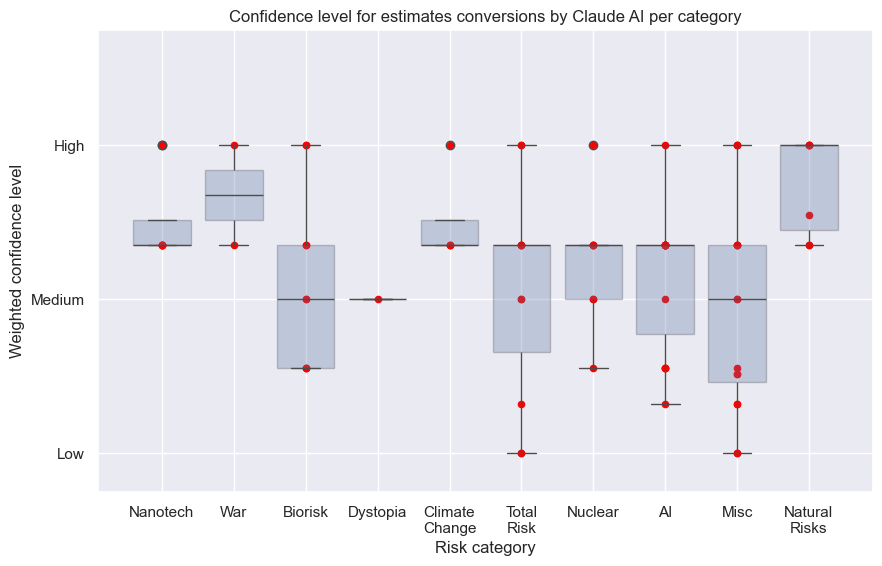

In [114]:
# Visualize the weighted confidence for each category.
# Start plot from 1 since it's the lowest confidence level
ax = sns.boxplot(x='category_alias', y='weighted_confidence_mean', data=df, boxprops=dict(alpha=0.3))
df.plot(kind='scatter', x='category_alias', y='weighted_confidence_mean', color='red', figsize=(10, 6), ax=ax)
ax.set_ylim(.25, 1.25)
# Set y tick labels to Low, Medium and High using the mapping above
ax.set_yticks([1/3, 2/3, 1], ['Low', 'Medium', 'High'])
ax.set_title('Confidence level for estimates conversions by Claude AI per category')
ax.set_ylabel('Weighted confidence level')
ax.set_xlabel('Risk category')

Now apply the weights to obtain a weighted average per category.

In [115]:
df_by_category = df.groupby('risk_category').apply(lambda x: np.average(x['per_century_risk'], weights=x['weighted_confidence_mean']))

# Visualize the calculated mean with the actual values.


/var/folders/gp/134vcy4x6c19634zvbkbff900000gn/T/ipykernel_18164/1739411070.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_by_category = df.groupby('risk_category').apply(lambda x: np.average(x['per_century_risk'], weights=x['weighted_confidence_mean']))


Text(0.5, 0, 'Risk category')

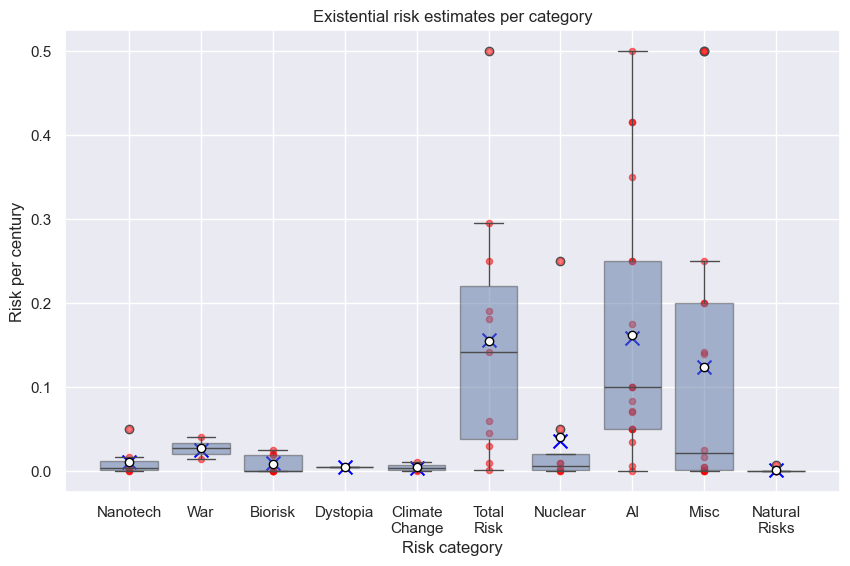

In [116]:
# Plot the risk categories in a box plot.
ax = sns.boxplot(x='category_alias', y='per_century_risk', data=df, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"}, boxprops=dict(alpha=0.5))

# Plot the actual values on top.
df.plot(kind='scatter', x='category_alias', y='per_century_risk', color='red', alpha=0.5, figsize=(10, 6), ax=ax)

# Plot the weighted mean on.
categories = [categories_aliases[cat] for cat in df_by_category.index]
ax.scatter(x=categories, y=df_by_category, color='blue', marker='x', s=100)

# Set the title and labels
ax.set_title('Existential risk estimates per category')
ax.set_ylabel('Risk per century')
ax.set_xlabel('Risk category')

## Conclusions

# Patterns in Existential Risk Estimates: A Deep Dive

When examining our dataset of existential risk estimates, several patterns emerge that tell us about how experts view different potential threats to humanity. Let's explore what the data reveals about these risk assessments and the confidence levels associated with them.

## Risk Level Distribution

Perhaps the most salient pattern in our data is how the risk estimates vary across different categories. **War** emerges as the category with both the highest median risk and the largest spread in estimates. This wide range of estimates, from near zero to about 90%, suggests significant disagreement among experts about the likelihood of war leading to existential catastrophe.

Artificial Intelligence follows as our second-highest risk category. Like war, AI risk estimates show considerable spread, though not quite as dramatic. This variation might reflect the inherent uncertainty in predicting the outcomes of a technology that's still rapidly evolving.

In contrast, Natural Risks and Dystopia show remarkably low risk estimates with minimal spread. This consistency among experts is particularly interesting – it suggests a strong consensus that natural disasters pose a relatively small existential threat compared to human-made risks.

## The Confidence Puzzle

One of the most intriguing patterns emerges when we look at how confident experts are in their estimates. Curiously, we find an inverse relationship between risk levels and confidence: categories with higher risk estimates tend to have lower confidence levels, and vice versa.

Natural Risks and Climate Change show the highest confidence levels. This makes intuitive sense for natural risks – we have historical data and scientific models to help us understand things like asteroid impacts or supervolcanoes. Climate Change estimates, while serious, benefit from decades of scientific research and modeling.

The lower confidence levels in AI and War risk estimates tell another story. These categories involve complex human systems, unpredictable technological advancement, and intricate social and political factors. The uncertainty here reflects the inherent difficulty in predicting human behavior and technological development.

## The Impact of Weighting

When we applied confidence-based weights to our analysis, we discovered something remarkable: weighted means tend to be lower than unweighted means. This suggests that experts who are more confident in their estimates generally predict lower risks than their less confident colleagues.

This effect is particularly pronounced in the War category, where the weighted mean falls significantly below the median. This might indicate that experts who have studied war-related risks most deeply are actually more optimistic about our chances of avoiding catastrophe.

## The Outlier Story

Almost every category in our dataset shows outliers, but they tell an asymmetric story. We see outliers predominantly on the high end of risk estimates, with very few on the low end. This creates a right-skewed distribution that suggests while most experts cluster around more moderate estimates, there's a consistent minority who see significantly higher risks.

The most extreme outliers appear in the War and Total Risk categories, representing some experts' views that these threats pose nearly certain existential risk. These outlying views, while minority positions, raise important questions about worst-case scenarios that perhaps deserve special attention.

## Final Thoughts

These patterns reveal a complex landscape of existential risk assessment. While we see strong consensus in some areas (like natural risks), other domains show significant uncertainty and disagreement. The inverse relationship between risk levels and confidence suggests that the threats we worry about most are also the ones we understand least well.

This analysis helps us understand not just the risks themselves, but also how experts think about and quantify these risks. It highlights areas where we might need more research and areas where expert consensus might guide policy and preparation efforts.

Would you like to explore any of these patterns in more detail? We could dive deeper into specific correlations, examine distribution shapes within categories, or investigate how different types of experts view these risks.

We see that the weighted means are mostly close to the actual mean, but are a little bit lower for categories where the values are more spread out.